In [27]:
import geopandas as gpd
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

In [28]:
# Filter the GeoDataFrame by country (replace 'country_name' and 'country_column' with your actual values)
country_name = "Afghanistan"  # Example country
country_column = "adm0_name"  # Column name containing country names in the shapefile

In [40]:
# Load the shapefile into a GeoDataFrame
shapefile_path = "../data/g2015_2014_2/g2015_2014_2.shp"
gdf = gpd.read_file(shapefile_path)

In [51]:
# Assuming your geodataframe is named 'gdf'
gdf.columns = [col.lower() for col in gdf.columns]

In [52]:
gdf.rename(columns={col: col.lower() for col in gdf.columns}, inplace=True)

In [54]:
gdf_filtered = gdf[gdf[country_column] == country_name]

In [55]:
gdf_filtered.sample(4)

,adm2_code,adm2_name,str2_year,exp2_year,adm1_code,adm1_name,status,disp_area,adm0_code,adm0_name,shape_leng,shape_area,geometry
31219,99913,Jalalabad,2004,3000,292,Nangarhar,Member State,NO,1,Afghanistan,0.213845,0.002316,"POLYGON ((70.46151 34.40978, 70.45988 34.41163..."
31165,3743,Rostaq,1000,3000,300,Takhar,Member State,NO,1,Afghanistan,2.222712,0.188922,"POLYGON ((69.73721 37.38504, 69.73803 37.38268..."
30976,3532,Nawur,1000,3000,279,Ghazni,Member State,NO,1,Afghanistan,4.203909,0.508291,"POLYGON ((68.1233 34.16137, 68.11919 34.15944,..."
31264,99958,Maymana,2004,3000,278,Faryab,Member State,NO,1,Afghanistan,0.563428,0.014691,"POLYGON ((64.88537 35.97379, 64.87892 35.97054..."


In [43]:
gdf_filtered.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

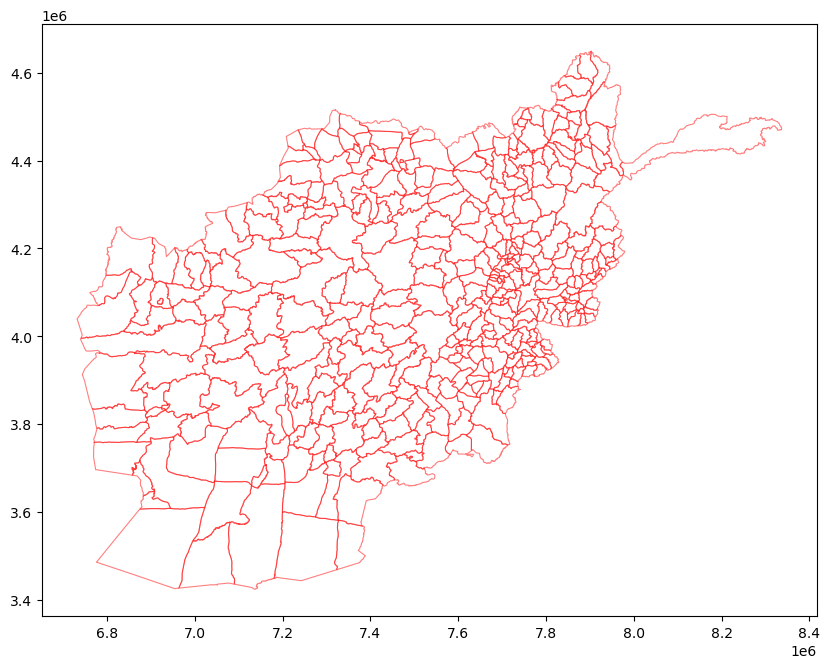

In [46]:
# Plotting the filtered polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the filtered geometries
# merged_gdf.plot(ax=ax, 
gdf_filtered.plot(ax=ax, 
                alpha=0.5, 
                # edgecolor='k', 
                edgecolor='r', 
                facecolor='none', 
                linewidth=0.8)

In [47]:
# Add basemap using contextily (requires Web Mercator projection)
try:
    # Convert to Web Mercator for basemap compatibility
    # merged_gdf_web = merged_gdf.to_crs(epsg=3857)
    gdf_filtered = gdf_filtered.to_crs(epsg=3857)
    ctx.add_basemap(ax, 
                   source=ctx.providers.OpenStreetMap.Mapnik, 
                   attribution_size=6,
                   zoom=19)
except Exception as e:
    print(f"Basemap not added due to: {str(e)}")

KeyboardInterrupt: 

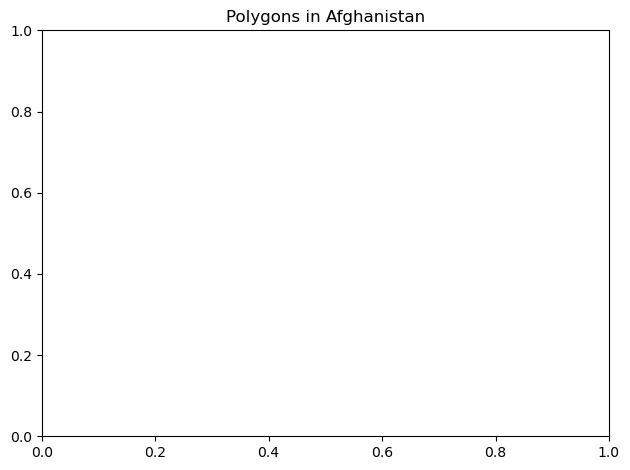

In [48]:
# Customize plot
plt.title(f"Polygons in {country_name}")
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [49]:
# Connect to SQLite database
db_path = "../flablog/instance/db.sqlite"
conn = sqlite3.connect(db_path)

In [19]:
# Load the table from SQLite database into a DataFrame
table_name = "correlation"
df_sql = pd.read_sql_query(f"SELECT * FROM {table_name} where {country_column} = '{country_name}'", conn)

# Close the database connection
conn.close()

In [25]:
df_sql.sample(4)

,id,adm0_name,adm2_code,adm2_name,correlation
158,159,Afghanistan,3751,khasuruzgan,-0.213911
245,246,Afghanistan,3591,qarabagh,-0.237948
222,223,Afghanistan,3611,nejrab,-0.163589
66,67,Afghanistan,3702,dandwapatan,0.139207


In [21]:
df_sql.describe()

,id,adm2_code,correlation
count,342.000000,342.000000,342.000000
mean,171.500000,37420.456140,-0.192982
std,98.871128,46041.455254,0.159296
min,1.000000,3448.000000,-0.626229
25%,86.250000,3590.250000,-0.303381
50%,171.500000,3698.000000,-0.196171
75%,256.750000,99921.750000,-0.111050
max,342.000000,100027.000000,0.646959


In [56]:
# Join the SQL table to the filtered GeoDataFrame using the common ID
# Replace 'id_column' with the actual column name used in both datasets
# id_column = "id"  # Common ID column name
id_column = "adm2_code"
merged_gdf = gdf_filtered.merge(df_sql, left_on=id_column, right_on=id_column, how='left')

# Optional: Convert back to GeoDataFrame if geometry was lost (shouldn't be necessary)
if not isinstance(merged_gdf, gpd.GeoDataFrame):
    merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

# Now you can use the merged GeoDataFrame
print(merged_gdf.head())

   adm2_code adm2_name_x  str2_year  exp2_year  adm1_code adm1_name  \
0       3505  Qala-e-Kah       1000       3000        277     Farah   
1       3504    Pushtrod       1000       3000        277     Farah   
2       3506     Shibkoh       1000       3000        277     Farah   
3       3499       Farah       1000       3000        277     Farah   
4       3676        Kang       1000       3000        293    Nimroz   

         status disp_area  adm0_code  adm0_name_x  shape_leng  shape_area  \
0  Member State        NO          1  Afghanistan    3.080581    0.336144   
1  Member State        NO          1  Afghanistan    1.074139    0.041174   
2  Member State        NO          1  Afghanistan    2.821954    0.263788   
3  Member State        NO          1  Afghanistan    3.870752    0.326498   
4  Member State        NO          1  Afghanistan    2.285347    0.108799   

                                            geometry     id  adm0_name_y  \
0  POLYGON ((61.85315 32.52808, 61

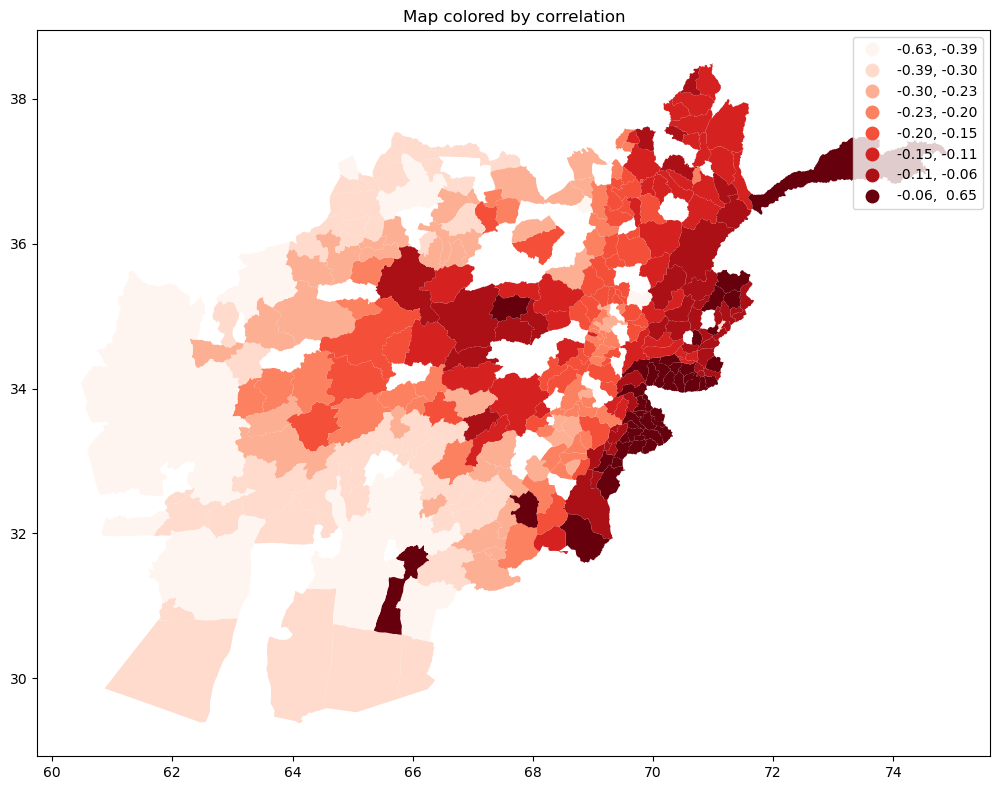

In [64]:
import matplotlib.colors as colors

# For continuous data with a color gradient
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(
    column='correlation',
    ax=ax,
    legend=True,
    cmap='Reds',  # Choose a colormap: viridis, plasma, inferno, magma, etc.
    scheme='quantiles',  # Classification scheme: equal_interval, quantiles, etc.
    k=8,  # Number of classes    
)
plt.title('Map colored by correlation')
plt.tight_layout()
plt.show()